## Generate Cities List

In [1]:
import os,sys,inspect
import requests
import pandas as pd
import random
import time
import math
import matplotlib.pyplot as plt
import numpy as np
from pylab import *
from scipy import stats
from citipy import citipy

current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
import api_keys

In [2]:
df_all_cities = pd.read_csv(citipy._world_cities_csv_path)

In [128]:
# Create dataframe of random cities
# Northern Hemisphere Latitude: 0 - 90 degrees
# Southern Hemisphere Latitude: -1 - -90 degrees

df_city = pd.DataFrame()

# Create 10 bins for both northern and southern hemisphere
southern_bins = pd.qcut(df_all_cities.loc[df_all_cities.Latitude < 0].Latitude, q=10, precision=0)
northern_bins = pd.qcut(df_all_cities.loc[df_all_cities.Latitude >= 0].Latitude, q=10, precision=0)

df_all_cities['latitude_bin'] = pd.concat([southern_bins, northern_bins])

# sample x cities from each bin
# Since we have 10 bins for each hemisphere, we'll end up with a total of 2(10x) cities in the output
sample_size = 100
for bin in df_all_cities.latitude_bin.unique():
    df_city = df_city.append(df_all_cities.loc[df_all_cities.latitude_bin == bin, ['Country', 'City', 'Latitude', 'Longitude', 'latitude_bin']].sample(sample_size))

df_city.rename(columns={
    'Country':'country',
    'City':'city',
    'Latitude':'latitude',
    'Longitude':'longitude'
}, inplace=True)

# If latitude is less than 0, mark as southern, else northern
df_city['hemisphere'] = ['southern' if l < 0 else 'northern' for l in df_city['latitude']]
df_city['country'] = [c.upper() for c in df_city['country']]

df_city.head()

,country,city,latitude,longitude,latitude_bin,hemisphere
43446,US,hobart,41.532222,-87.255000,"(41.0, 45.0]",northern
34528,RO,traian,43.766667,25.000000,"(41.0, 45.0]",northern
43420,US,cedar lake,41.364722,-87.441111,"(41.0, 45.0]",northern
21071,IT,treia,43.316667,13.316667,"(41.0, 45.0]",northern
43903,US,hopkinton,42.228611,-71.523056,"(41.0, 45.0]",northern


In [129]:
print(df_city[['hemisphere']].value_counts())

hemisphere
southern      1000
northern      1000
dtype: int64


In [130]:
def GetWeatherData(lat, lon):
    response = requests.get(f'https://api.openweathermap.org/data/2.5/weather?units=imperial&lat={lat}&lon={lon}&appid={api_keys.weather_api_key}').json()
    return response['main']['temp'], response['main']['humidity'], response['clouds']['all'], response['wind']['speed'], response['main']['temp_max']

increment = 50
throttle = 0
counter = 1

for index, row in df_city.iterrows():
    temp, humidity, clouds, wind, temp_max = GetWeatherData(df_city.loc[index,'latitude'], df_city.loc[index,'longitude'])
    df_city.loc[index,'temp'] = temp
    df_city.loc[index,'humidity'] = humidity
    df_city.loc[index,'clouds'] = clouds
    df_city.loc[index,'wind'] = wind
    df_city.loc[index,'temp_max'] = temp_max

    print(f'Loading data for {df_city.loc[index].city}: {counter} of {len(df_city)}')

    # Throttle the calls a little bit
    if throttle == increment - 1 and counter != len(df_city):
        print(f'Throttling API Calls')
        time.sleep(60)
        throttle = -1

    throttle += 1
    counter += 1

print('Done')
df_city.loc[:, ['country', 'city', 'latitude', 'longitude', 'hemisphere', 'temp', 'humidity', 'clouds', 'wind', 'temp_max']].to_csv("../Resources/city_weather.csv", index=False)

06 of 2000
Loading data for racovita: 1507 of 2000
Loading data for matasari: 1508 of 2000
Loading data for huntsville: 1509 of 2000
Loading data for doclin: 1510 of 2000
Loading data for pechea: 1511 of 2000
Loading data for senovo: 1512 of 2000
Loading data for rasinari: 1513 of 2000
Loading data for temirgoyevskaya: 1514 of 2000
Loading data for salmon creek: 1515 of 2000
Loading data for anoka: 1516 of 2000
Loading data for dalnerechensk: 1517 of 2000
Loading data for salasu de sus: 1518 of 2000
Loading data for topana: 1519 of 2000
Loading data for skofja loka: 1520 of 2000
Loading data for obarsia-closani: 1521 of 2000
Loading data for cookshire: 1522 of 2000
Loading data for bronzani majdan: 1523 of 2000
Loading data for slobozia-ciorasti: 1524 of 2000
Loading data for tselina: 1525 of 2000
Loading data for staroshcherbinovskaya: 1526 of 2000
Loading data for borgaro torinese: 1527 of 2000
Loading data for vinderei: 1528 of 2000
Loading data for kayiry: 1529 of 2000
Loading data

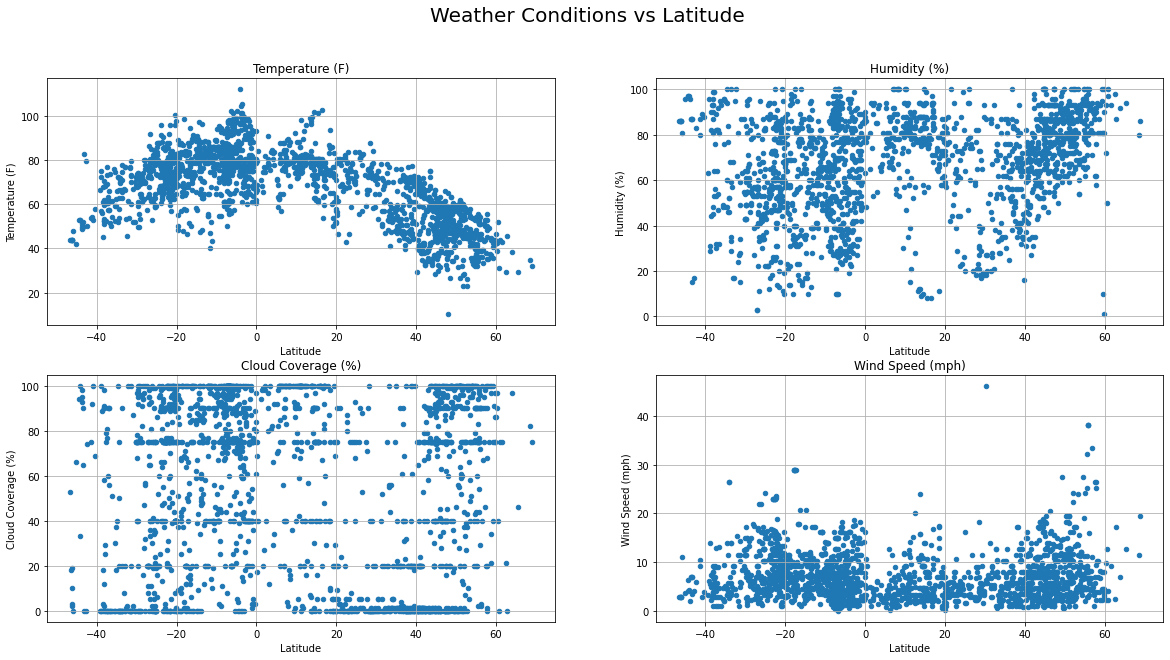

In [131]:
fig, axs = plt.subplots(2, 2)

df_city.plot.scatter(x='latitude', y='temp', grid=True, ax=axs[0][0])
axs[0][0].set_ylabel('Temperature (F)')
axs[0][0].set_xlabel('Latitude')
axs[0][0].title.set_text('Temperature (F)')

df_city.plot.scatter(x='latitude', y='humidity', grid=True, ax=axs[0][1])
axs[0][1].set_ylabel('Humidity (%)')
axs[0][1].set_xlabel('Latitude')
axs[0][1].title.set_text('Humidity (%)')

df_city.plot.scatter(x='latitude', y='clouds', grid=True, ax=axs[1][0]).set_ylabel('Cloud Coverage (%)')
axs[1][0].set_ylabel('Cloud Coverage (%)')
axs[1][0].set_xlabel('Latitude')
axs[1][0].title.set_text('Cloud Coverage (%)')

df_city.plot.scatter(x='latitude', y='wind', grid=True, ax=axs[1][1]).set_ylabel('Wind Speed (mph)')
axs[1][1].set_ylabel('Wind Speed (mph)')
axs[1][1].set_xlabel('Latitude')
axs[1][1].title.set_text('Wind Speed (mph)')

fig.set_size_inches(20, 10)
fig.suptitle('Weather Conditions vs Latitude', fontsize=20)
plt.show()

## Linear Regression

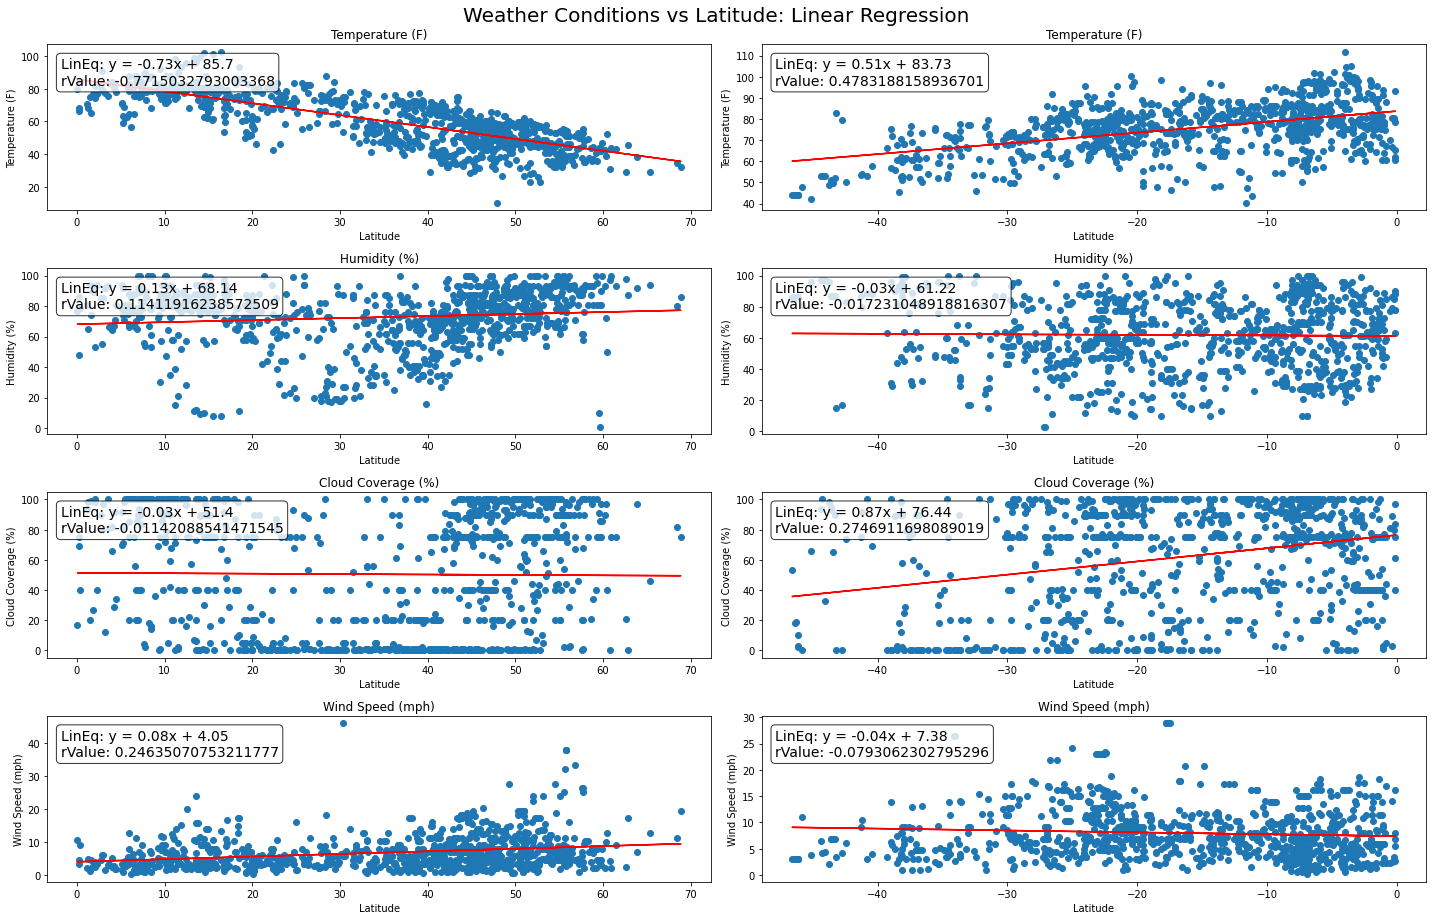

In [132]:
weather_metrics = {
    'temp':'Temperature (F)',
    'humidity': 'Humidity (%)',
    'clouds': 'Cloud Coverage (%)',
    'wind':'Wind Speed (mph)'
    }

y = 0
fig, axs = plt.subplots(4, 2)

for m in weather_metrics:
    # Run through a loop for both the northen and southern hemisphere
    for i in arange(2):

        # On every first run though this loop, do northern. On the second, do southern
        df_hemisphere = df_city.loc[(df_city.hemisphere == ('northern' if i == 0 else 'southern')), ['latitude', m]]

        x_values = df_hemisphere.latitude
        y_values = df_hemisphere[m]

        slope, intercept, rvalue, pvalue, stderr = stats.linregress(x_values, y_values)
        regress_values = (slope * x_values) + intercept

        axs[y][i].scatter(x_values,y_values)
        axs[y][i].plot(x_values,regress_values, color='red')
        axs[y][i].set_xlabel('Latitude')
        axs[y][i].set_ylabel(weather_metrics[m])
        axs[y][i].title.set_text(weather_metrics[m])

        textstr = f'LinEq: y = {round(slope, 2)}x + {round(intercept, 2)}\nrValue: {rvalue}'
        props = dict(boxstyle='round', facecolor='white', alpha=0.8)
        axs[y][i].text(0.02, 0.92, textstr, transform=axs[y][i].transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    y += 1
fig.set_size_inches(20, 13)
fig.suptitle('Weather Conditions vs Latitude: Linear Regression', fontsize=20)
plt.tight_layout()
plt.show()
